# Libraries and Tools

In [6]:
from brian_graph import Graph
from solver import *
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [7]:
#graph = Graph("inputs/84_50.in")
graph = Graph("inputs/practice.in") # Homework example
#graph = Graph("inputs/264_50.in") # Pauls Example
#graph = Graph("inputs/basic.in") # Basic Example

Successful instance of Graph class


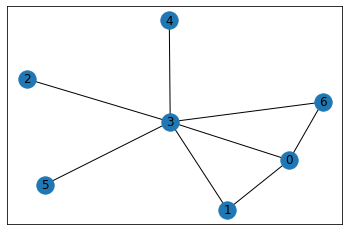

In [8]:
nx.draw_networkx(graph.G)

# Integer Linear Programming

In [9]:
graph.ILP()

Academic license - for non-commercial use only
Optimize a model with 22 rows, 91 columns and 170 nonzeros
Model has 210 quadratic objective terms
Variable types: 0 continuous, 91 integer (91 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 2e+00]
  QObjective range [2e+00, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 13.0000000
Presolve removed 7 rows and 35 columns
Presolve time: 0.00s
Presolved: 141 rows, 182 columns, 490 nonzeros
Variable types: 0 continuous, 182 integer (182 binary)

Root relaxation: objective 3.000000e+00, 23 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    3.00000    0    8   13.00000    3.00000  76.9%     -    0s
H    0     0                       9.0000000    3.00000  66.7%     -    0s
     0     0    3.00000   

In [10]:
# Output format
"""
Drop-Off Locations: Soda Dwinelle Campanile Barrows Soda
Number of Distinct Locations Dropped Off: 3
Soda Cory
Dwinelle Wheeler RSF
Campanile Campanile
"""
def car_cycle(graph, arrangement_matrix):
    def drop_off_compression(cycle):
        locations = []
        previous = None
        for location in cycle:
            if location != previous:
                locations.append(location)
            previous = location
        return locations
    drop_offs = []
    for c in range(arrangement_matrix.shape[1]):
        drop_off_vertex = np.where(arrangement_matrix[:, c] == 1)[0][0]
#         location = graph.vertex_to_location[drop_off_vertex]
        drop_offs.append(drop_off_vertex)
    return drop_off_compression(drop_offs)

def num_distinct_drop_offs(cycle):
    return len(set(cycle[1:-1]))

def homes_at_drop_offs(graph, walking_matrix):
    homes_set = set(graph.list_of_houses)
    TAs, D = [], {}
    for i in range(len(graph.list_of_locations)):
        if graph.list_of_locations[i] in homes_set:
            TAs.append((i, graph.list_of_locations[i]))
    for index, home in TAs:
        drop_off_vertex = np.where(walking_matrix[:, index] == 1)[0][0]
        if drop_off_vertex not in D:
            D[drop_off_vertex] = [index,]
        else:
            D.get(drop_off_vertex).append(index)
    return D

cycle = car_cycle(graph, graph.optimal_A())
num = num_distinct_drop_offs(cycle)
D = homes_at_drop_offs(graph, graph.optimal_W())
cycle, num, D

([0, 3, 0], 1, {3: [2, 3, 4, 5]})

In [11]:
#convertToFile(cycle, D, "outputs/practice.out", graph.list_of_locations)

In [12]:
graph.list_of_locations

['Soda', 'Dwinelle', 'Wheeler', 'Campanile', 'Cory', 'RSF', 'Barrows']